In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,Embedding,GlobalAveragePooling1D,Dropout,LSTM,Conv1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model

In [2]:
NB_START_EPOCHS = 10  # Número de iteraciones de entrenamiento
BATCH_SIZE = 512  # Tamaño de grupos usados en entrenamiento
FAST_TEXT_DIM = 300  # Número de dimensiones los embeddings GloVe
seq_length = 33

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import string
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import missingno as msno
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import codecs

from tqdm import tqdm

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
#Reference https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

def clean(tweet):
    tweet = str(tweet)

    tweet=tweet.lower()

    #Remove html tags
    tweet=re.sub('<.*?>','',tweet)

    #Remove text in square brackets
    tweet=re.sub('\[.*?\]','',tweet)

    #Remove hyperlinks
    tweet=re.sub('https?://\S+|www\.\S+','',tweet)


    return tweet

In [5]:
train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
target = train['sentiment']

In [6]:
train_model = train.copy()
train_model.dropna(inplace=True)
train_model['clean_text']=train_model['text'].apply(clean)
train_model['clean_selected_text']=train_model['selected_text'].apply(clean)
train_model = train_model.reset_index()
train_model.head()

,index,textID,text,selected_text,sentiment,clean_text,clean_selected_text
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"i`d have responded, if i were going","i`d have responded, if i were going"
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego!!!,sooo sad
2,2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,bullying me
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,leave me alone
4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"sons of ****, why couldn`t they put them on t...","sons of ****,"


In [7]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train_model[['sentiment','clean_text','textID']],train_model['clean_selected_text'],
                                               test_size=0.2,random_state=42,stratify=train_model['sentiment'])

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train Forma',X_train.shape,' Y_train Forma ',Y_train.shape)
print('X_val Forma',X_val.shape,' Y_val Forma ',Y_val.shape)
print('X_test Forma',X_test.shape,' Y_test Forma ',Y_test.shape)

X_train Forma (17587, 3)  Y_train Forma  (17587,)
X_val Forma (5496, 3)  Y_val Forma  (5496,)
X_test Forma (4397, 3)  Y_test Forma  (4397,)


In [8]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(train_model[['sentiment','clean_text','textID']],train_model['clean_selected_text'],
                                               test_size=0.2,random_state=42,stratify=train_model['sentiment'])

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,
                                               test_size=0.2,random_state=42,stratify=X_train['sentiment'])

X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

Y_train=Y_train.reset_index(drop=True)
Y_val=Y_val.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)

print('X_train Forma',X_train.shape,' Y_train Forma ',Y_train.shape)
print('X_val Forma',X_val.shape,' Y_val Forma ',Y_val.shape)
print('X_test Forma',X_test.shape,' Y_test Forma ',Y_test.shape)

X_train Forma (17587, 3)  Y_train Forma  (17587,)
X_val Forma (5496, 3)  Y_val Forma  (5496,)
X_test Forma (4397, 3)  Y_test Forma  (4397,)


In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='UNK',filters='')
tokenizer.fit_on_texts(X_train['clean_text'].values+' '+X_train['sentiment'].values)

X_train_clean_text = tokenizer.texts_to_sequences(X_train['sentiment'].values+' '+X_train['clean_text'].values)
X_val_clean_text = tokenizer.texts_to_sequences(X_val['sentiment'].values+' '+X_val['clean_text'].values)
X_test_clean_text = tokenizer.texts_to_sequences(X_test['sentiment'].values+' '+X_test['clean_text'].values)

X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_clean_text,maxlen=seq_length,padding='post')
X_val_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_val_clean_text,maxlen=seq_length,padding='post')
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_clean_text,maxlen=seq_length,padding='post')

print('The shape of X_train_tokens ',X_train_tokens.shape)
print('The shape of X_val_tokens ',X_val_tokens.shape)
print('The shape of X_test_tokens ',X_test_tokens.shape)

The shape of X_train_tokens  (17587, 33)
The shape of X_val_tokens  (5496, 33)
The shape of X_test_tokens  (4397, 33)


In [10]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

553it [00:00, 5529.33it/s]

loading word embeddings...


2000005it [05:59, 5562.94it/s]

found 1999997 word vectors


In [11]:
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

32146


In [12]:
embedding_matrix = np.zeros((vocab_size, 300 ))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:    
        embedding_matrix[i] = embedding_vector

In [13]:
print(X_train_tokens.T[0][0:3])
print(X_train['sentiment'].values[0:3])

[3 6 7]
['neutral' 'positive' 'negative']


In [14]:
# Creación de indices

def get_start_end_index(X_data,Y_data):
    start_index=np.zeros((X_data.shape[0],32),dtype='int32')
    end_index=np.zeros((X_data.shape[0],32),dtype='int32')

    for k in range(X_data.shape[0]):
        tx1=" ".join(X_data['clean_text'][k].split())
        tx2=" ".join(Y_data[k].split())
        # Se encuentra en indice de inicio y el de finalización
        idx=tx1.find(tx2)

        # Se insertan unos por cada caracter presente
        chars=np.zeros(len(tx1))
        chars[idx:idx+len(tx2)]=1

        # Creación de offsets con (inicio, fin) para cada palabra 
        offsets=[]
        j=0
        for i in tx1.split():
            offsets.append((j,j+len(i)+1))
            j+=len(i)+1

        vals=[]
        for i,(o1,o2) in enumerate(offsets):
            if(sum(chars[o1:o2])>0):
                vals.append(i)

        if(len(vals)>0 and len(vals)<=32):
            start_index[k,vals[0]]=1
            end_index[k,vals[-1]]=1
        else:
            start_index[k,0]=1
            end_index[k,-1]=1
    return start_index,end_index

In [15]:
Y_tr_1,Y_tr_2=get_start_end_index(X_train,Y_train)
Y_val_1,Y_val_2=get_start_end_index(X_val,Y_val)
Y_te_1,Y_te_2=get_start_end_index(X_test,Y_test)

In [16]:
X_train['clean_text'][202]

' sc2 will be released before d3  hopefully!'

In [17]:
Y_train[202]

'hopefully!'

In [18]:
X_train_tokens[202]

array([   6, 9860,   52,   26, 2178,  196, 9861, 3099,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [19]:
Y_tr_1[202]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [20]:
Y_tr_2[202]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [21]:
import os
if not os.path.exists('./fast-text'):
    os.makedirs('./fast-text')

In [22]:
# Red neuronal convolucional


inp = Input((seq_length,),name='input')
x = Embedding(vocab_size,300,weights=[embedding_matrix],input_length=seq_length,trainable=False)(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)

y1 = Dense(100, activation="relu")(x)
y1 = Dropout(0.25)(y1)
y1 = Dense(32, activation="softmax",name='output1')(y1)

y2 = Dense(100, activation="relu")(x)
y2 = Dropout(0.25)(y2)
y2 = Dense(32, activation="softmax",name='output2')(y2)

model=Model(inputs=[inp],outputs=[y1,y2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy())

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 33)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      9643800     input[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 33, 200)      320800      embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 200)          0           bidirectional[0][0]              
______________________________________________________________________________________________

In [23]:
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

log_dir='./fast-text/logs'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="./fast-text/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [25]:
callback=[tensorboard_callback,checkpoint]
model.fit(X_train_tokens,[Y_tr_1,Y_tr_2],batch_size=32,epochs=20,callbacks=callback,
           validation_data=(X_val_tokens,[Y_val_1,Y_val_2]))

Epoch 1/20
550/550 [==============================] - 87s 143ms/step - loss: 4.8069 - output1_loss: 1.7908 - output2_loss: 3.0161 - val_loss: 3.6701 - val_output1_loss: 1.4251 - val_output2_loss: 2.2451

Epoch 00001: val_loss improved from inf to 3.67013, saving model to ./fast-text/weights-01-3.6701.hdf5
Epoch 2/20
550/550 [==============================] - 79s 144ms/step - loss: 3.6549 - output1_loss: 1.4251 - output2_loss: 2.2298 - val_loss: 3.3322 - val_output1_loss: 1.3473 - val_output2_loss: 1.9849

Epoch 00002: val_loss improved from 3.67013 to 3.33223, saving model to ./fast-text/weights-02-3.3322.hdf5
Epoch 3/20
550/550 [==============================] - 77s 141ms/step - loss: 3.2889 - output1_loss: 1.3215 - output2_loss: 1.9673 - val_loss: 3.0980 - val_output1_loss: 1.2859 - val_output2_loss: 1.8121

Epoch 00003: val_loss improved from 3.33223 to 3.09798, saving model to ./fast-text/weights-03-3.0980.hdf5
Epoch 4/20
550/550 [==============================] - 77s 139ms/step - 

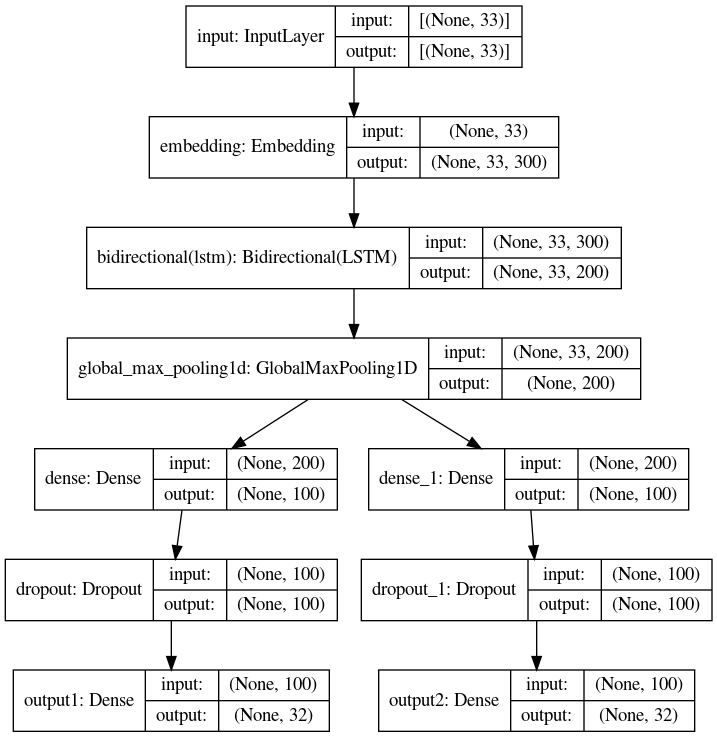

In [26]:
tf.keras.utils.plot_model(model, './fast-text/model.png',show_shapes=True)

In [27]:
model.load_weights('./fast-text/weights-12-2.8139.hdf5')

OSError: Unable to open file (unable to open file: name = './fast-text/weights-12-2.8139.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
# Metrica definida

def jaccard(str1, str2):
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [29]:
st_idx,end_idx = model.predict(X_test_tokens,batch_size=32,verbose=1)

138/138 [==============================] - 5s 28ms/step


In [30]:
def compute_jaccard(st_idx,end_idx,X,Y):
    all_jaccard=[]
    df=pd.DataFrame(columns=['clean_text','selected_text','predicted','jaccard','sentiment'])
    for i in range(len(st_idx)):
        initial=np.argmax(st_idx[i])
        final=np.argmax(end_idx[i])
        sent2=" ".join(X['clean_text'][i].split()[initial:final+1])
        sent1=Y[i] 
        df.loc[i,'clean_text']=X['clean_text'][i]   
        df.loc[i,'selected_text']=sent1
        df.loc[i,'predicted']=sent2
        df.loc[i,'sentiment']=X['sentiment'][i]
        jaccard_score=jaccard(sent1,sent2)
        df.loc[i,'jaccard']=jaccard_score
        all_jaccard.append(jaccard_score)
    return np.mean(np.array(all_jaccard)),df

In [31]:
X_test

,sentiment,clean_text,textID
0,negative,misses driving already,197aa929a2
1,positive,name the rest? let`s see. mystery jets are pr...,7648a76c96
2,neutral,anyways have a severe headache ryt now! i jst...,14fc34a4fb
3,neutral,25-man ulduar is hard...,50662e359b
4,negative,cried like a fukn baby today durin da senior s...,b66219e011
...,...,...,...
4392,negative,so lathargic... definitely need today to rest....,d715de6cbf
4393,positive,"yess, they came to amsterdam on the 18th of a...",3b84c35810
4394,positive,chillaxing in hyde park,a7b2b3ec1d
4395,neutral,had the hottest and stressiest day at work f ...,6c0d1d0655


In [32]:
score,df = compute_jaccard(st_idx,end_idx,X_test,Y_test)
print(score)

0.6061584807983105
